In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import LabelEncoder

# 1-> LOAD AND PREPROCESS

In [2]:

#Load the dataset
df = pd.read_csv("D:\Retail_store2.csv")

# Convert Date to datetime object and sort nicely
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# create Date-based feature (Seasonality)
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Day'] = df['Date'].dt.day


In [3]:
# Encode Categorical Columns(Turn text into numbers)

cat_cols = ['Category','Region','Weather Condition','Seasonality','Store ID','Product ID']

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

In [4]:
# Define the predictors(X) and the target (y)

features = ['Price','Discount','Competitor Pricing','Inventory Level','Holiday/Promotion'] + \
           cat_cols + ['Month','DayOfWeek','Day']

target = 'Units Sold'

X = df[features]
y = df[target]

# 2) TIME-SERIES SPLIT (80/20)

In [5]:
# We calculate the index to split at 80%
split_idx = int(len(df) * 0.8)

#Split the data
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Training on {len(X_train)} rows,Testing on {len(X_test)} rows.")

Training on 58480 rows,Testing on 14620 rows.


# 3) TRAIN MODELS

In [6]:
# Model A) XGBoost Regressor (REAL XGBoost)

print("\nTraining XGBoost Model....")

xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    n_jobs=4,
    random_state=42
)

xgb_model.fit(X_train, y_train)

print("XGBoost Training Complete!")



Training XGBoost Model....
XGBoost Training Complete!


In [7]:
import os
# Set this to '4' or however many cores your PC has. 
# It prevents the library from trying to search for them and crashing.
os.environ['LOKY_MAX_CPU_COUNT'] = '4'


from sklearn.ensemble import HistGradientBoostingRegressor

# Model B) Histogram Gradient Boosing(The "LightGBM")

print("Training HistGradientBoosting Model.....")
hgb_model = HistGradientBoostingRegressor(
    learning_rate=0.05,
    max_iter=500,
    max_depth=5,
    random_state=42
)
hgb_model.fit(X_train, y_train)
print("Training Complete!")

Training HistGradientBoosting Model.....
Training Complete!


# 4) EVALUATE AND GET RESULTS

In [8]:
def get_metrics(model_name,y_true,y_pred):
    rmse = np.sqrt(mean_squared_error(y_true,y_pred))
    mae = mean_absolute_error(y_true,y_pred)
    print(f"{model_name} -> RMSE: {rmse:.2f} | MAE : {mae:.2f}")

In [9]:
# Predict on the test set
xgb_preds = xgb_model.predict(X_test)
hgb_preds = hgb_model.predict(X_test)

print("\n--- FINAL RESULTS ---")
get_metrics("XGBoost Equivalent",y_test,xgb_preds)
get_metrics("LightGBM Equivalent",y_test,hgb_preds)


--- FINAL RESULTS ---
XGBoost Equivalent -> RMSE: 89.25 | MAE : 69.48
LightGBM Equivalent -> RMSE: 87.83 | MAE : 68.73


# REVENUE LIFT SIMULATION

In [10]:
print("Starting Revenue Simulation with XGBoost....")

# we will test inctresing\decreasing prices by 5% and 10%
price_multipliers = [0.90,0.95,1.0,1.05,1.10]

# We create a dataframe to store the revenue outcomes for each  price point
scenario_revenues = pd.DataFrame(index=X_test.index)

# Simulate each price point
for m in price_multipliers:
    temp_X = X_test.copy()
    # Adjust the price column
    temp_X['Price'] = temp_X['Price'] * m
    # Demand at this new price?
    pred_demand = xgb_model.predict(temp_X)
    # Demand cannot be negative
    pred_demand = np.maximum(pred_demand,0)

    # Revenue
    scenario_revenues[m] = (temp_X['Price']) * pred_demand

# Optimal Revenue
simulated_revenue = scenario_revenues.max(axis=1)

# "Baseline Revenue" is what actually happened in history
# (Actual price * Actual units sold)
actual_revenue = X_test['Price'] * y_test


Starting Revenue Simulation with XGBoost....


In [11]:
# Calculate Total lift
total_actual = actual_revenue.sum()
total_simulated = simulated_revenue.sum()
lift_percentage = ((total_simulated - total_actual) / total_actual) * 100

print("-"*30)
print(f"Total Actual Revenue :     ${total_actual:,.2f}")
print(f"Total Simulated Revenue:   ${total_simulated:,.2f}")
print("-"*30)
print(f"REVENUE LIFT :{lift_percentage:.2f}%")
print("-"*30)

------------------------------
Total Actual Revenue :     $108,768,700.04
Total Simulated Revenue:   $120,815,082.80
------------------------------
REVENUE LIFT :11.08%
------------------------------


# VISUALIZATION

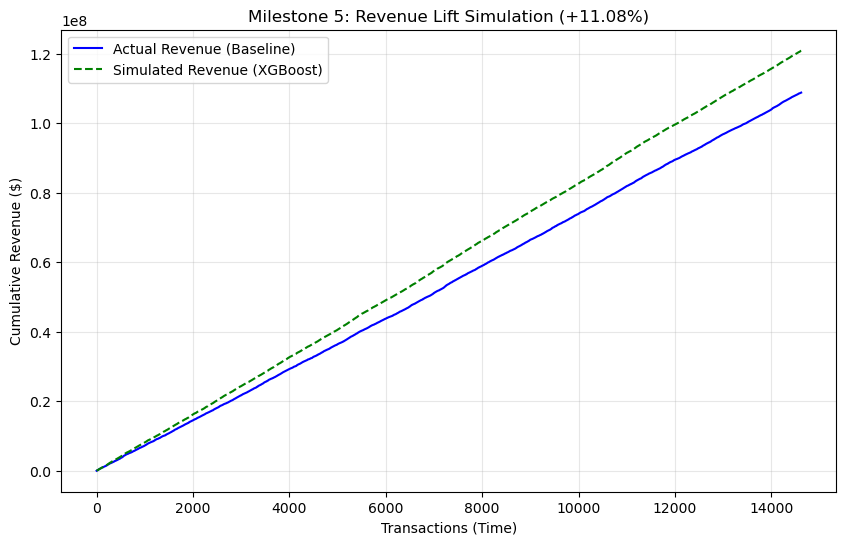

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))


plt.plot(actual_revenue.cumsum().values,label="Actual Revenue (Baseline)",color = 'blue')
plt.plot(simulated_revenue.cumsum().values,label="Simulated Revenue (XGBoost)",color='green',linestyle='--')


plt.title(f'Milestone 5: Revenue Lift Simulation (+{lift_percentage:.2f}%)')
plt.xlabel('Transactions (Time)')
plt.ylabel('Cumulative Revenue ($)')
plt.legend()
plt.grid(True,alpha=0.3)
plt.show()

In [13]:
import joblib
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# 1. We need to save the 'Encoders' so the API understands text input (like 'Winter' or 'Texas')
# Since your previous code overwrote them, we will reload the data briefly to learn the mappings again.
encoder_dict = {}
cat_cols = ['Category', 'Region', 'Weather Condition', 'Seasonality', 'Store ID', 'Product ID']

# Reload just to get the text values
temp_df = pd.read_csv("D:\Retail_store2.csv") 

print("Re-learning categories for saving...")
for col in cat_cols:
    le = LabelEncoder()
    # Fit the encoder on the original text data
    le.fit(temp_df[col].astype(str))
    # Store it in our dictionary
    encoder_dict[col] = le

# 2. Select your best model
# In your simulation, you used 'hgb_model', so we will save that one.
final_model = hgb_model 

# 3. Save the files to your computer
joblib.dump(final_model, 'pricing_model.joblib')
joblib.dump(encoder_dict, 'encoders.joblib')

print("SUCCESS! Files saved: 'pricing_model.joblib' and 'encoders.joblib'")

Re-learning categories for saving...
SUCCESS! Files saved: 'pricing_model.joblib' and 'encoders.joblib'
